In [1]:
from scipy.spatial.distance import squareform, pdist, cdist
from itertools import islice, combinations, product
from pyclustering.cluster.kmedoids import kmedoids
from collections import defaultdict
from sklearn.cluster import KMeans
from functools import partial

import os
import time
import graco
import random
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
# import Bio.UniProt.GOA as GOA
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set()
pd.set_option("display.max_columns", 20)

DATA_DIRECTORY = "/home/clusterduck123/Desktop/git/supplements/data"
CPP_DIRECTORY = "/home/clusterduck123/Desktop/git/graco/graco/cpp"

In [3]:
RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw_data"
PPI_DIRECTORY = f"{DATA_DIRECTORY}/PPI"
ANNOTATIONS_DIRECTORY = f"{DATA_DIRECTORY}/annotations"
MATRIX_DIRECTORY = f"{DATA_DIRECTORY}/matrix"
CLUSTERS_DIRECTORY = f"{DATA_DIRECTORY}/clusters"

if not os.path.exists(DATA_DIRECTORY):
    os.makedirs(DATA_DIRECTORY)
        
if not os.path.exists(RAW_DATA_DIRECTORY):
    os.makedirs(RAW_DATA_DIRECTORY)     
    
if not os.path.exists(PPI_DIRECTORY):
    os.makedirs(PPI_DIRECTORY)
    
if not os.path.exists(ANNOTATIONS_DIRECTORY):
    os.makedirs(ANNOTATIONS_DIRECTORY)
    
if not os.path.exists(MATRIX_DIRECTORY):
    os.makedirs(MATRIX_DIRECTORY)
    
if not os.path.exists(CLUSTERS_DIRECTORY):
    os.makedirs(CLUSTERS_DIRECTORY)

# TVD

In [7]:
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
GDV = graco.orbits(PPI_nx)
GCV = graco.coefficients(GDV)

In [5]:
df0 = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd0.txt", delimiter=' ')
df1 = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd1.txt", delimiter=' ')
df2 = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd2.txt", delimiter=' ')
df3 = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd3.txt", delimiter=' ')

#df4 = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_1tvd0.txt", delimiter=' ')
#
#sqD0 = squareform(df0)
#sqD1 = squareform(df1)
#sqD2 = squareform(df2)
#sqD3 = squareform(df3)

KeyboardInterrupt: 

In [ ]:
df0.index = df0.columns
df1.index = df1.columns
df2.index = df2.columns
df3.index = df3.columns

In [ ]:
for (gene1, gene2) in combinations(df0.columns[df0.isna().all()], 2):
    df0[gene1][gene2] = 0
    df0[gene2][gene1] = 0
df0 = df0.fillna(1)
np.fill_diagonal(df0.values, 0)

for (gene1, gene2) in combinations(df1.columns[df1.isna().all()], 2):
    df1[gene1][gene2] = 0
    df1[gene2][gene1] = 0
df1 = df1.fillna(1)
np.fill_diagonal(df1.values, 0)

for (gene1, gene2) in combinations(df2.columns[df2.isna().all()], 2):
    df2[gene1][gene2] = 0
    df2[gene2][gene1] = 0
df2 = df2.fillna(1)
np.fill_diagonal(df2.values, 0)

for (gene1, gene2) in combinations(df3.columns[df3.isna().all()], 2):
    df3[gene1][gene2] = 0
    df3[gene2][gene1] = 0
df3 = df3.fillna(1)
np.fill_diagonal(df3.values, 0)

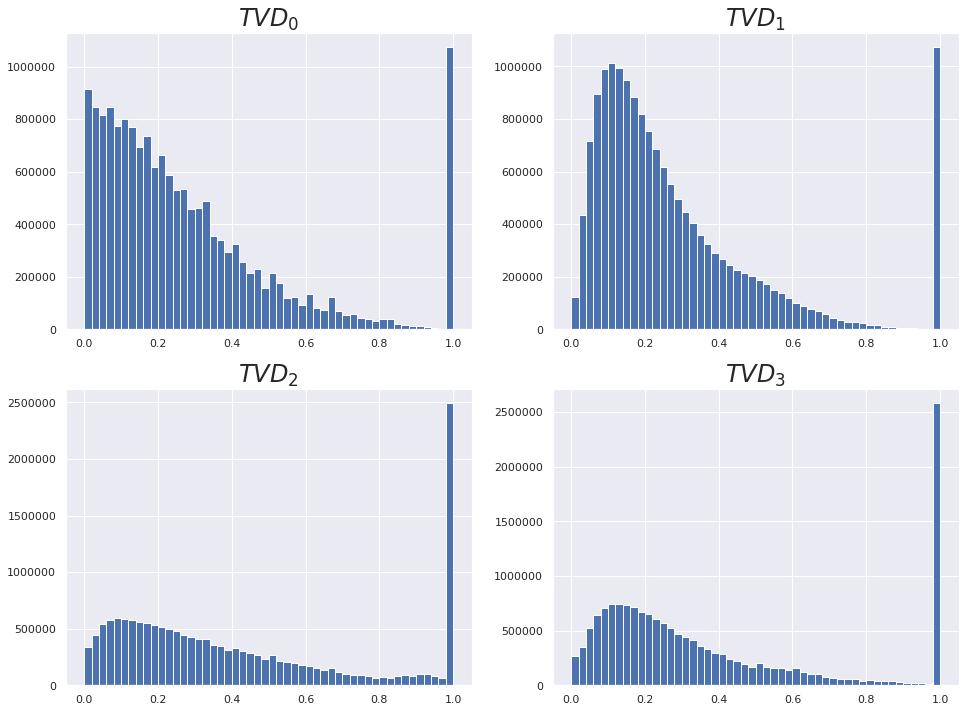

In [8]:
fig, axes = plt.subplots(2,2, figsize=(16,12))
fig.patch.set_alpha(0)

axes[0,0].set_title('$TVD_0$', fontsize=24)
axes[0,0].hist(squareform(df0), bins=50);
axes[0,1].set_title('$TVD_1$', fontsize=24)
axes[0,1].hist(squareform(df1), bins=50);
axes[1,0].set_title('$TVD_2$', fontsize=24)
axes[1,0].hist(squareform(df2), bins=50);
axes[1,1].set_title('$TVD_3$', fontsize=24)
axes[1,1].hist(squareform(df3), bins=50);

fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

# Distance distributions

In [34]:
MATRIX_NAME0 = "sc_BioGRID_tvd0"
D_tvd0_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME0}.txt", delimiter=' ')

MATRIX_NAME1 = "sc_BioGRID_tvd1"
D_tvd1_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME1}.txt", delimiter=' ')

MATRIX_NAME2 = "sc_BioGRID_tvd2"
D_tvd2_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME2}.txt", delimiter=' ')

MATRIX_NAME3 = "sc_BioGRID_tvd3"
D_tvd3_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME3}.txt", delimiter=' ')

MATRIX_NAME4 = "sc_BioGRID_2tvd0"
D_tvd4_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME4}.txt", delimiter=' ')

D_tvd0123 = np.nanmean([D_tvd0_df.values, 
                        D_tvd1_df.values, 
                        D_tvd2_df.values, 
                        D_tvd3_df.values], axis=0)

D_tvd0_df.index = D_tvd0_df.columns
D_tvd1_df.index = D_tvd1_df.columns
D_tvd2_df.index = D_tvd2_df.columns
D_tvd3_df.index = D_tvd3_df.columns
D_tvd4_df.index = D_tvd4_df.columns
D_tvd0123_df = pd.DataFrame(D_tvd0123, 
                            index=D_tvd0_df.index, 
                            columns=D_tvd0_df.index)

d_tvd0 = ~D_tvd0_df.isna().all()
d_tvd1 = ~D_tvd1_df.isna().all()
d_tvd2 = ~D_tvd2_df.isna().all()
d_tvd3 = ~D_tvd3_df.isna().all()
d_tvd4 = ~D_tvd4_df.isna().all()
d_tvd0123 = ~D_tvd0123_df.isna().all()

D_tvd0 = np.array(D_tvd0_df[d_tvd0].T[d_tvd0])
D_tvd1 = np.array(D_tvd1_df[d_tvd1].T[d_tvd1])
D_tvd2 = np.array(D_tvd2_df[d_tvd2].T[d_tvd2])
D_tvd3 = np.array(D_tvd3_df[d_tvd3].T[d_tvd3])
D_tvd4 = np.array(D_tvd4_df[d_tvd4].T[d_tvd4])
D_tvd0123 = np.array(D_tvd0123_df[d_tvd0123].T[d_tvd0123])

/home/clusterduck123/Desktop/git/supplements/venv/graco/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [35]:
MATRIX_NAME0 = "sc_BioGRID_hell0"
D_hellinger0_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME0}.txt", delimiter=' ')

MATRIX_NAME1 = "sc_BioGRID_hell1"
D_hellinger1_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME1}.txt", delimiter=' ')

MATRIX_NAME2 = "sc_BioGRID_hell2"
D_hellinger2_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME2}.txt", delimiter=' ')

MATRIX_NAME3 = "sc_BioGRID_hell3"
D_hellinger3_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME3}.txt", delimiter=' ')

MATRIX_NAME4 = "sc_BioGRID_2hell0"
D_hellinger4_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME4}.txt", delimiter=' ')

D_hellinger0123 = np.nanmean([D_hellinger0_df.values, 
                              D_hellinger1_df.values, 
                              D_hellinger2_df.values, 
                              D_hellinger3_df.values], axis=0)

D_hellinger0_df.index = D_hellinger0_df.columns
D_hellinger1_df.index = D_hellinger1_df.columns
D_hellinger2_df.index = D_hellinger2_df.columns
D_hellinger3_df.index = D_hellinger3_df.columns
D_hellinger4_df.index = D_hellinger4_df.columns
D_hellinger0123_df = pd.DataFrame(D_hellinger0123, 
                                  index=D_hellinger0_df.index, 
                                  columns=D_hellinger0_df.index)

d_hellinger0 = ~D_hellinger0_df.isna().all()
d_hellinger1 = ~D_hellinger1_df.isna().all()
d_hellinger2 = ~D_hellinger2_df.isna().all()
d_hellinger3 = ~D_hellinger3_df.isna().all()
d_hellinger4 = ~D_hellinger4_df.isna().all()
d_hellinger0123 = ~D_hellinger0123_df.isna().all()

D_hellinger0 = np.array(D_hellinger0_df[d_hellinger0].T[d_hellinger0])
D_hellinger1 = np.array(D_hellinger1_df[d_hellinger1].T[d_hellinger1])
D_hellinger2 = np.array(D_hellinger2_df[d_hellinger2].T[d_hellinger2])
D_hellinger3 = np.array(D_hellinger3_df[d_hellinger3].T[d_hellinger3])
D_hellinger4 = np.array(D_hellinger4_df[d_hellinger4].T[d_hellinger4])
D_hellinger0123 = np.array(D_hellinger0123_df[d_hellinger0123].T[d_hellinger0123])

/home/clusterduck123/Desktop/git/supplements/venv/graco/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


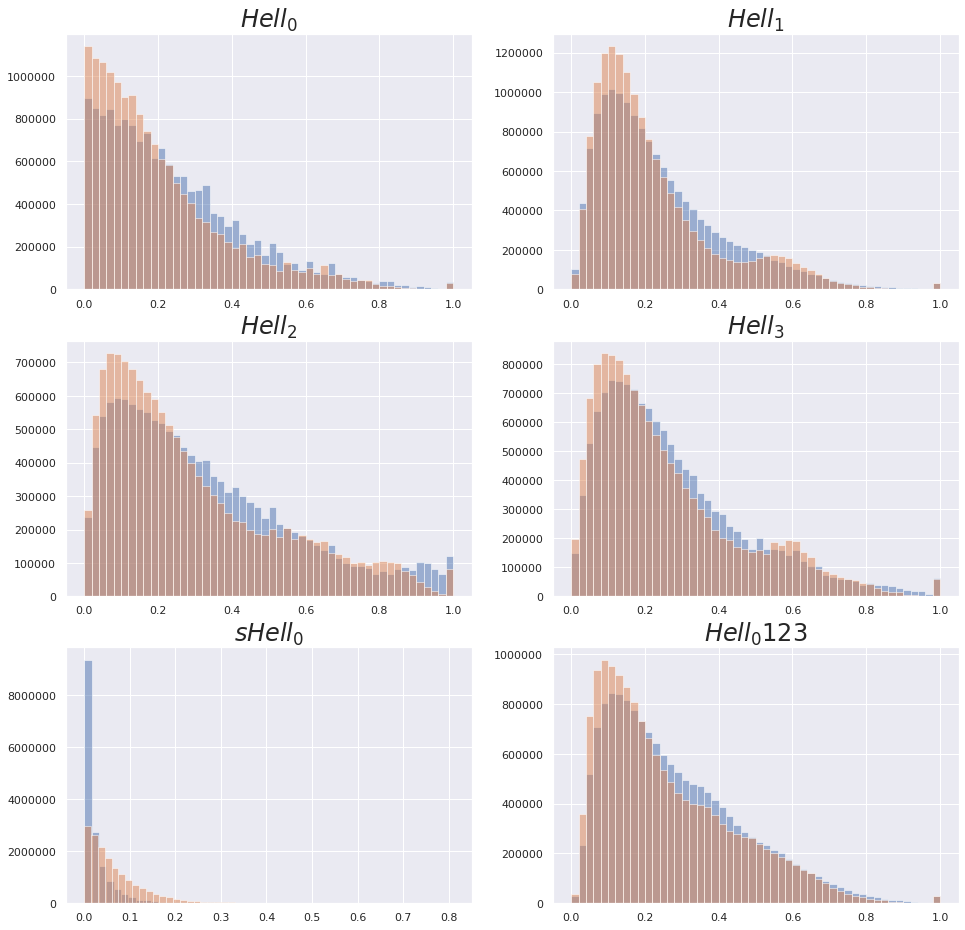

In [36]:
fig, axes = plt.subplots(3,2, figsize=(16,16))
fig.patch.set_alpha(0)

axes[0,0].set_title('$TVD_0$', fontsize=24)
axes[0,0].hist(squareform(D_tvd0), bins=50, alpha=0.5);
axes[0,1].set_title('$TVD_1$', fontsize=24)
axes[0,1].hist(squareform(D_tvd1), bins=50, alpha=0.5);
axes[1,0].set_title('$TVD_2$', fontsize=24)
axes[1,0].hist(squareform(D_tvd2), bins=50, alpha=0.5);
axes[1,1].set_title('$TVD_3$', fontsize=24)
axes[1,1].hist(squareform(D_tvd3), bins=50, alpha=0.5);
axes[2,0].set_title('$sTVD_0$', fontsize=24)
axes[2,0].hist(squareform(D_tvd4), bins=50, alpha=0.5);
axes[2,1].set_title('$TVD_0123$', fontsize=24)
axes[2,1].hist(squareform(D_tvd0123), 
               bins=50, alpha=0.5);


axes[0,0].set_title('$Hell_0$', fontsize=24)
axes[0,0].hist(squareform(D_hellinger0), bins=50, alpha=0.5);
axes[0,1].set_title('$Hell_1$', fontsize=24)
axes[0,1].hist(squareform(D_hellinger1), bins=50, alpha=0.5);
axes[1,0].set_title('$Hell_2$', fontsize=24)
axes[1,0].hist(squareform(D_hellinger2), bins=50, alpha=0.5);
axes[1,1].set_title('$Hell_3$', fontsize=24)
axes[1,1].hist(squareform(D_hellinger3), bins=50, alpha=0.5);
axes[2,0].set_title('$sHell_0$', fontsize=24)
axes[2,0].hist(squareform(D_hellinger4), bins=50, alpha=0.5);
axes[2,1].set_title('$Hell_0123$', fontsize=24)
axes[2,1].hist(squareform(D_hellinger0123), 
               bins=50, alpha=0.5);


fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

# All coefficients

In [244]:
# all Hells
D0_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_hell0.txt", delimiter=' ')
D1_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_hell1.txt", delimiter=' ')
D2_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_hell2.txt", delimiter=' ')
D3_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_hell3.txt", delimiter=' ')

D00_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_0hell0.txt", delimiter=' ')
D11_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_1hell1.txt", delimiter=' ')
D33_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_3hell3.txt", delimiter=' ')
D12_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_1hell2.txt", delimiter=' ')
D21_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_2hell1.txt", delimiter=' ')

D_hell = np.nanmean([D0_df.values, D1_df.values, D2_df.values, D3_df.values,
                D00_df.values, D11_df.values, D33_df.values, D12_df.values, D21_df.values], axis=0)

In [245]:
# all TVDs
D0_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd0.txt", delimiter=' ')
D1_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd1.txt", delimiter=' ')
D2_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd2.txt", delimiter=' ')
D3_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd3.txt", delimiter=' ')

D00_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_0tvd0.txt", delimiter=' ')
D11_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_1tvd1.txt", delimiter=' ')
D33_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_3tvd3.txt", delimiter=' ')
D12_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_1tvd2.txt", delimiter=' ')
D21_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_2tvd1.txt", delimiter=' ')

D_tvd = np.nanmean([D0_df.values, D1_df.values, D2_df.values, D3_df.values,
                D00_df.values, D11_df.values, D33_df.values, D12_df.values, D21_df.values], axis=0)

In [256]:
hist_tvd, bin_edges_tvd   = np.histogram(squareform(D_tvd) , bins=50, range=[0,1])
hist_hell, bin_edges_hell = np.histogram(squareform(D_hell), bins=50, range=[0,1])

In [263]:
df = pd.DataFrame({'TVD': squareform(D_tvd), 'Hell': squareform(D_hell)})

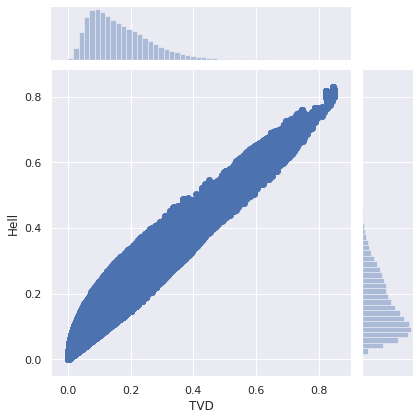

In [278]:
sns.jointplot(x="TVD", y="Hell", data=df);

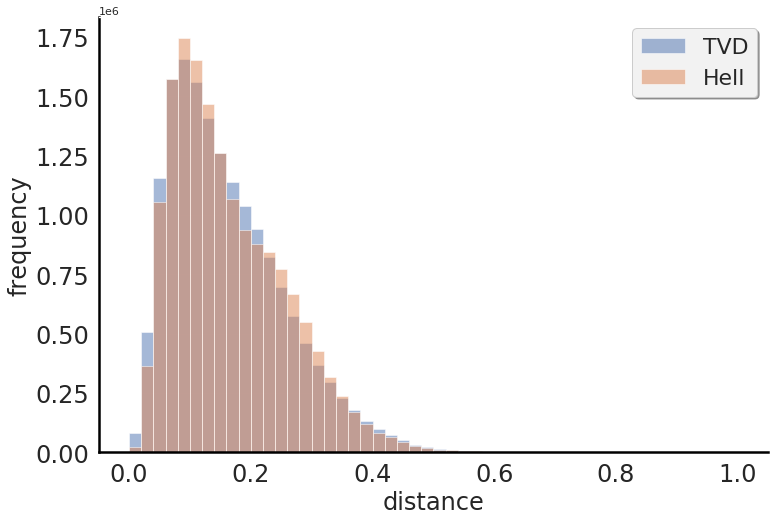

In [328]:
fig, ax = plt.subplots(figsize=(12,8))
fig.patch.set_alpha(0)

ax.hist(squareform(D_tvd)  , bins=50, label='TVD' , alpha=0.5, range=[0,1]);
ax.hist(squareform(D_hell) , bins=50, label='Hell', alpha=0.5, range=[0,1]);
ax.legend(fontsize=22, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);

ax.patch.set_alpha(0)

ax.set_xlabel('distance', fontsize=24)
ax.set_ylabel('frequency', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)

ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')

fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

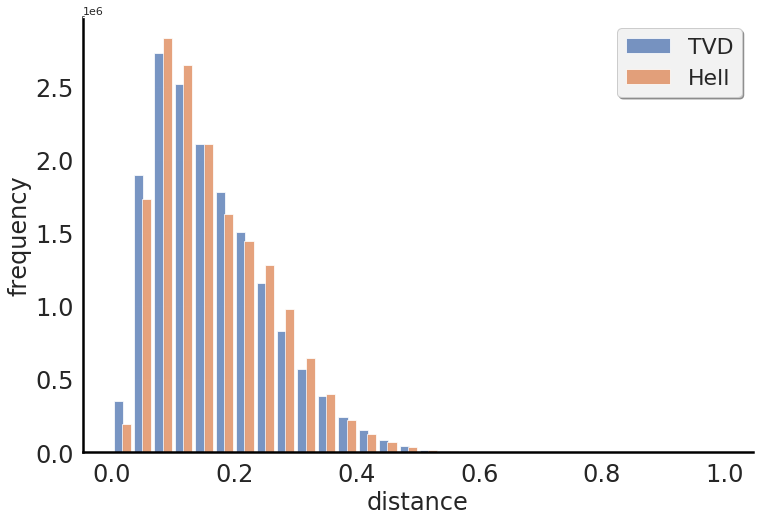

In [329]:
fig, ax = plt.subplots(figsize=(12,8))
fig.patch.set_alpha(0)

ax.hist([squareform(D_tvd),squareform(D_hell)],
         bins=30, 
         label=['TVD', 'Hell'],
         alpha=0.75,
         range=[0,1],
         width=0.015,);
ax.legend(fontsize=22, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);


ax.patch.set_alpha(0)

ax.set_xlabel('distance', fontsize=24)
ax.set_ylabel('frequency', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)

ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')


fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

# Ternary plots

In [7]:
_SQRT2 = np.sqrt(2) 

def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [8]:
v1x, v1y = 0, 0
v2x, v2y = np.sqrt(2), 0
v3x, v3y = np.sqrt(2)/2, np.sqrt(3/2)

v1 = np.array([v1x, v1y])
v2 = np.array([v2x, v2y])
v3 = np.array([v3x, v3y])

T = np.array([v1, v2, v3])
Tinv = np.array([
    [np.sqrt(2)/2, -1/np.sqrt(6)],
    [0, np.sqrt(2/3)]
])

In [9]:
Tinv@(np.array([0.2, 0.3, 0.5])@T)

array([0.3, 0.5])

In [10]:
# Get orbit-specific graphlet coefficients
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
PPI_GCV = graco.coefficients(PPI_nx)

N   = PPI_nx.number_of_nodes()
E   = PPI_nx.number_of_edges()
rho = nx.density(PPI_nx)
m   = int(N/2 - np.sqrt(N**2/4-E))
beta = 0.19772
r1 = 0.00285
r2 = 0.04325
r3 = 0.11563
r4 = 0.19750
r10 = 0.6445
r20 = 1.1850
r100 = 3.4575

In [12]:
PPI = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
PPI_GCV = graco.coefficients(PPI)

ER = nx.erdos_renyi_graph(N, rho)
ER_GCV = graco.coefficients(ER)

BA = nx.barabasi_albert_graph(N, m)
BA_GCV = graco.coefficients(BA)

WS = nx.watts_strogatz_graph(N, int(2*E/N), beta)
WS_GCV = graco.coefficients(WS)

GEO1 = nx.random_geometric_graph(N, radius=r1, dim=1)
GEO1_GCV = graco.coefficients(GEO1)

GEO2 = nx.random_geometric_graph(N, radius=r2, dim=2)
GEO2_GCV = graco.coefficients(GEO2)

GEO3 = nx.random_geometric_graph(N, radius=r3, dim=3)
GEO3_GCV = graco.coefficients(GEO3)

GEO4 = nx.random_geometric_graph(N, radius=r4, dim=4)
GEO4_GCV = graco.coefficients(GEO4)

GEO10 = nx.random_geometric_graph(N, radius=r10, dim=10)
GEO10_GCV = graco.coefficients(GEO10)

GEO20 = nx.random_geometric_graph(N, radius=r20, dim=20)
GEO20_GCV = graco.coefficients(GEO20)

GEO100 = nx.random_geometric_graph(N, radius=r100, dim=100)
GEO100_GCV = graco.coefficients(GEO100)

sample_dict = {'PPI'    : PPI_GCV['-1'],
               'ER'     :  ER_GCV['-1'], 
               'BA'     :  BA_GCV['-1'],
               'WS'     :  WS_GCV['-1'], 
               '$GEO_1$':GEO1_GCV['-1'],
               '$GEO_2$':GEO2_GCV['-1'],
               '$GEO_3$':GEO3_GCV['-1'],
               '$GEO_4$':GEO4_GCV['-1'],
                   }
sample_list = list(sample_dict.keys())
sample_len  = len(sample_list)

colors = sns.color_palette(n_colors=sample_len)
colors[3], colors[7] = colors[7], colors[3]

In [13]:
df = pd.DataFrame({'PPI'    : PPI_GCV['-1']['0']['3'].dropna(),
                   'ER'     :  ER_GCV['-1']['0']['3'].dropna(), 
                   'BA'     :  BA_GCV['-1']['0']['3'].dropna(), 
                   'WS'     :  WS_GCV['-1']['0']['3'].dropna(), 
                   '$GEO_1$':GEO1_GCV['-1']['0']['3'].dropna(),
                   '$GEO_2$':GEO2_GCV['-1']['0']['3'].dropna(),
                   '$GEO_3$':GEO3_GCV['-1']['0']['3'].dropna(),
                   '$GEO_4$':GEO4_GCV['-1']['0']['3'].dropna(),
                   })

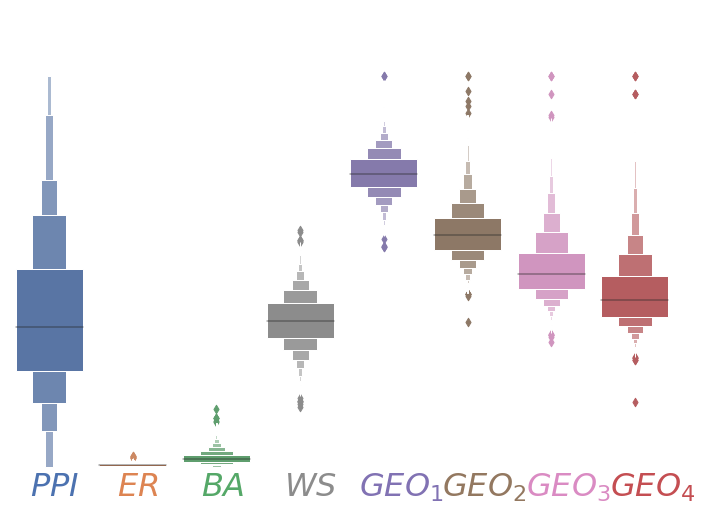

In [16]:
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_ylim([-buffer,1.1+buffer])
ax.set_xlim([-buffer,sample_len+10+buffer])
ax.axis('off')

ax.annotate(r'$PPI$' , (0-3*buffer  , -buffer), fontsize=32, color=colors[0])
ax.annotate(r'$ER$'  , (1-2.5*buffer, -buffer), fontsize=32, color=colors[1])
ax.annotate(r'$BA$'  , (2-2.5*buffer, -buffer), fontsize=32, color=colors[2])
ax.annotate(r'$WS$'  , (3-2.5*buffer, -buffer), fontsize=32, color=colors[3])
ax.annotate(r'$GEO_1$', (4-4*buffer  , -buffer), fontsize=32, color=colors[4])
ax.annotate(r'$GEO_2$', (5-4*buffer  , -buffer), fontsize=32, color=colors[5])
ax.annotate(r'$GEO_3$', (6-4*buffer  , -buffer), fontsize=32, color=colors[6])
ax.annotate(r'$GEO_4$', (7-4*buffer  , -buffer), fontsize=32, color=colors[7])

sns.boxenplot(data = df, ax=ax, palette=colors);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

In [44]:
? sns.boxenplot

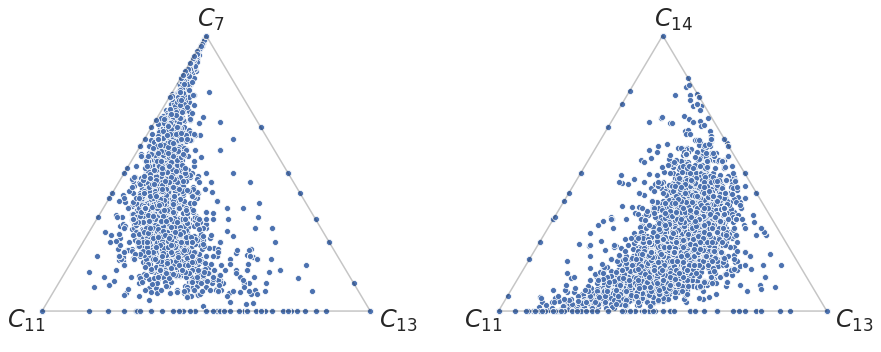

In [11]:
C2 = (PPI_GCV['-1']['2'][['11', '13', '7' ]]@T).dropna()
C3 = (PPI_GCV['-1']['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=axes[0], color=sns.color_palette()[0]);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=axes[1], color=sns.color_palette()[0]);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

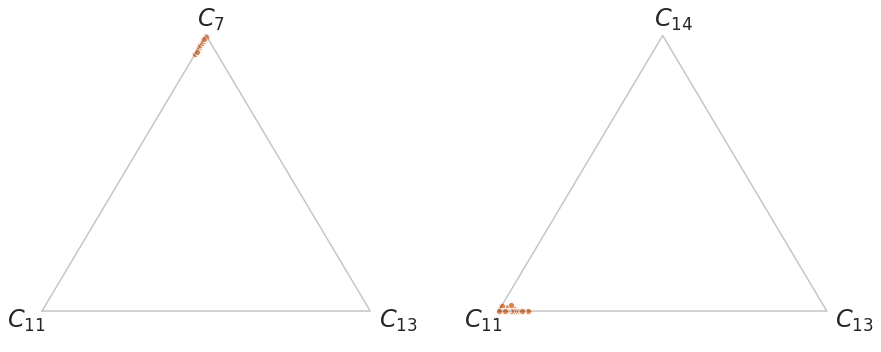

In [12]:
C2 = (ER_GCV['-1']['2'][['11', '13', '7' ]]@T).dropna()
C3 = (ER_GCV['-1']['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=axes[0], color=colors[1]);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=axes[1], color=colors[1]);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

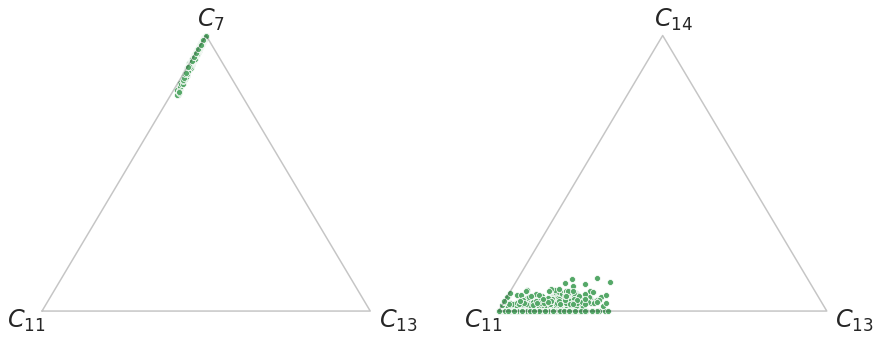

In [13]:
C2 = (BA_GCV['-1']['2'][['11', '13', '7' ]]@T).dropna()
C3 = (BA_GCV['-1']['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=axes[0], color=sns.color_palette()[2]);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=axes[1], color=sns.color_palette()[2]);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

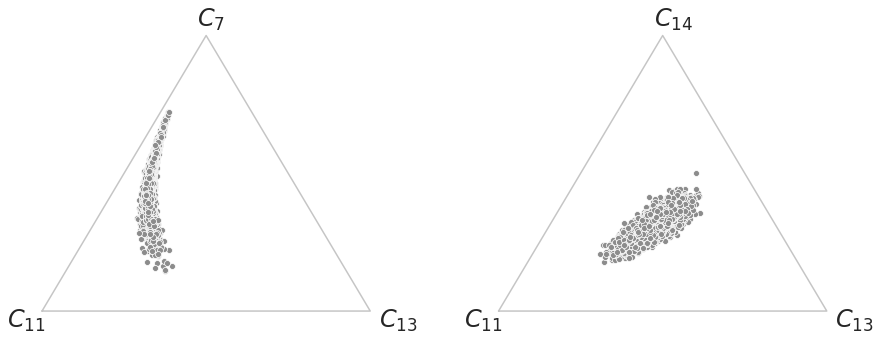

In [14]:
C2 = (WS_GCV['-1']['2'][['11', '13', '7' ]]@T).dropna()
C3 = (WS_GCV['-1']['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=axes[0], color=colors[3]);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=axes[1], color=colors[3]);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

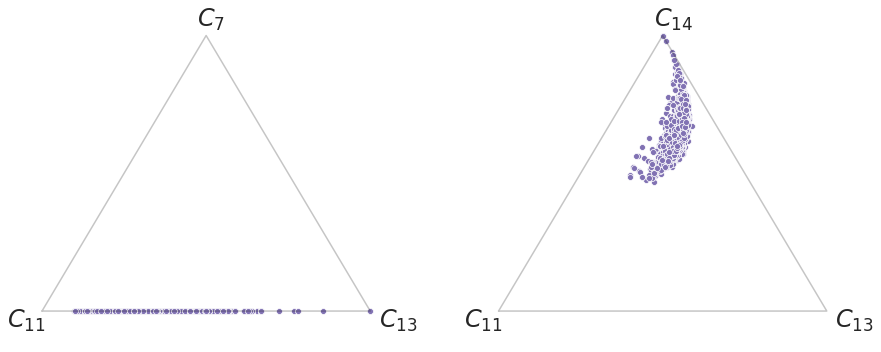

In [15]:
C2 = (GEO1_GCV['-1']['2'][['11', '13', '7' ]]@T).dropna()
C3 = (GEO1_GCV['-1']['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=axes[0], color=colors[4]);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=axes[1], color=colors[4]);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

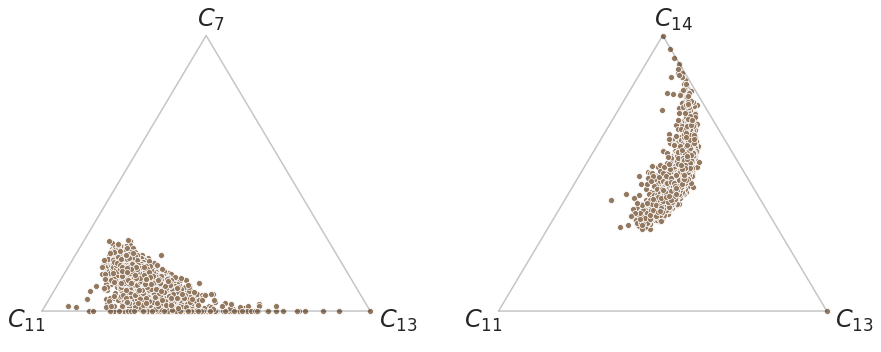

In [16]:
C2 = (GEO2_GCV['-1']['2'][['11', '13', '7' ]]@T).dropna()
C3 = (GEO2_GCV['-1']['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=axes[0], color=colors[5]);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=axes[1], color=colors[5]);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

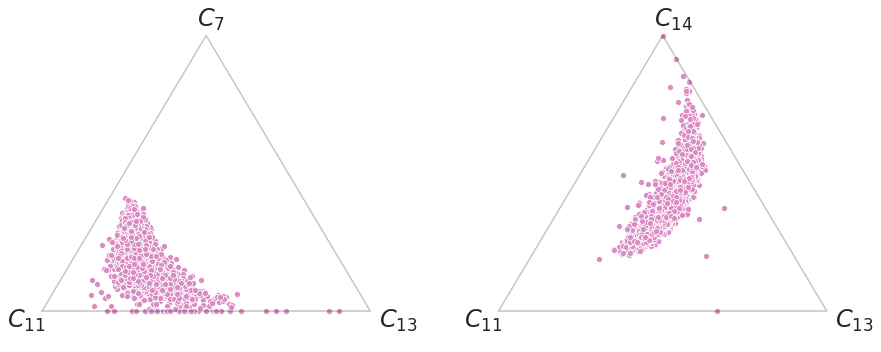

In [17]:
C2 = (GEO3_GCV['-1']['2'][['11', '13', '7' ]]@T).dropna()
C3 = (GEO3_GCV['-1']['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=axes[0], color=colors[6]);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=axes[1], color=colors[6]);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

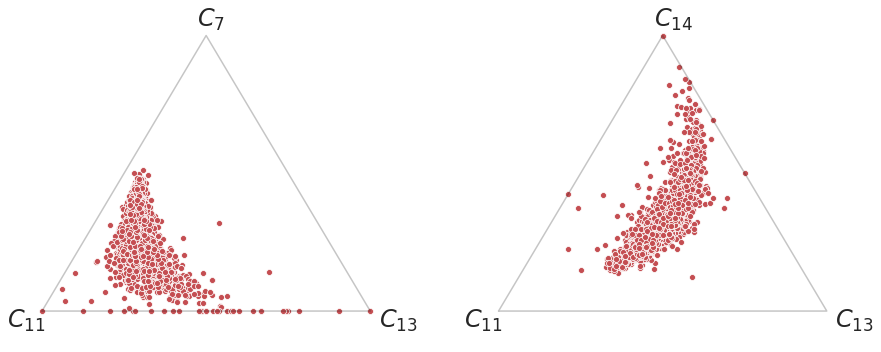

In [20]:
C2 = (GEO4_GCV['-1']['2'][['11', '13', '7' ]]@T).dropna()
C3 = (GEO4_GCV['-1']['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=axes[0], color=colors[7]);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=axes[1], color=colors[7]);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

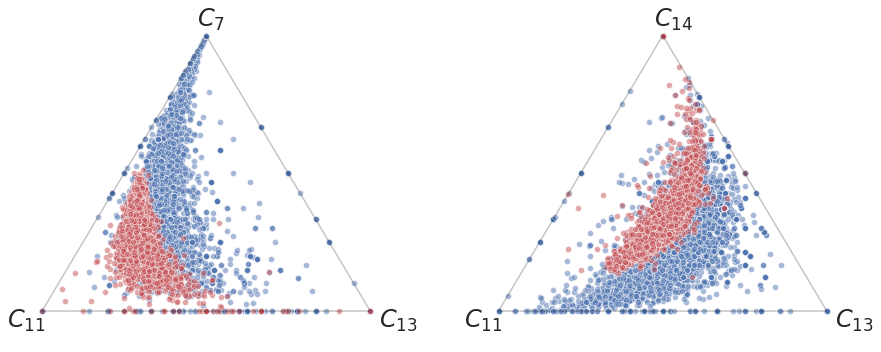

In [22]:
C21 = (PPI_GCV['-1']['2'][['11', '13', '7' ]]@T).dropna()
C31 = (PPI_GCV['-1']['3'][['11', '13', '14']]@T).dropna()

C22 = (GEO4_GCV['-1']['2'][['11', '13', '7' ]]@T).dropna()
C32 = (GEO4_GCV['-1']['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C21, x=0, y=1, ax=axes[0], color=colors[0], alpha=0.5);
sns.scatterplot(data = C22, x=0, y=1, ax=axes[0], color=colors[7], alpha=0.5);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C31, x=0, y=1, ax=axes[1], color=colors[0], alpha=0.5);
sns.scatterplot(data = C32, x=0, y=1, ax=axes[1], color=colors[7], alpha=0.5);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

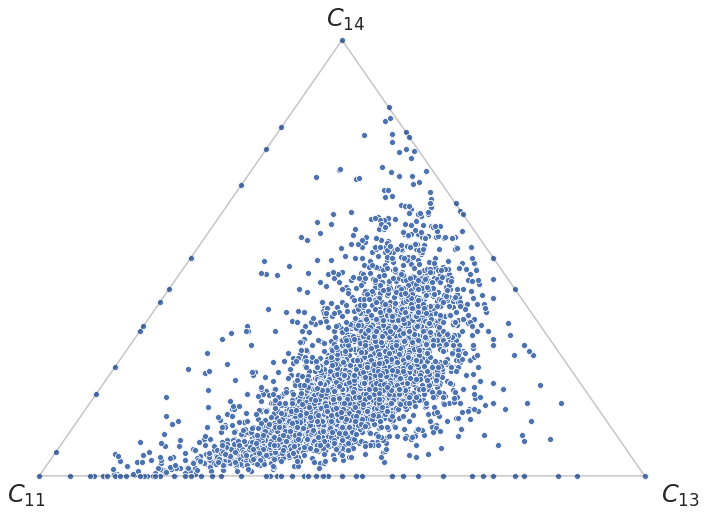

In [68]:
#Cluster coverage

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=ax);
ax.plot([0,np.sqrt(2)/2, np.sqrt(2), 0], [0,np.sqrt(3/2), 0, 0], 'k', alpha=0.25);

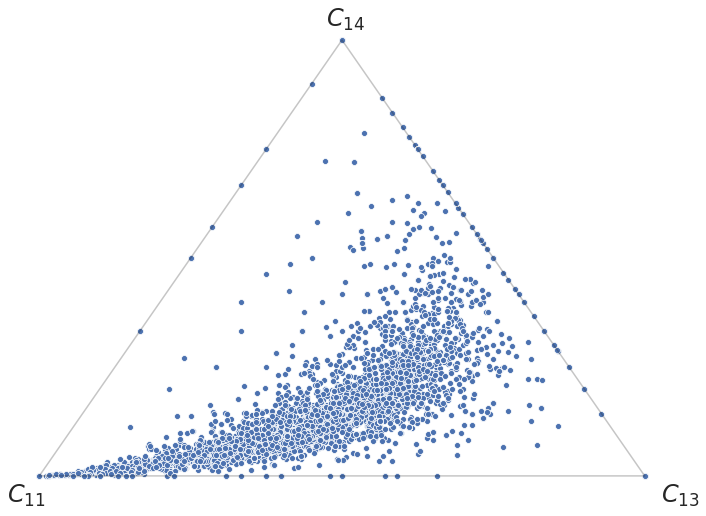

In [208]:
#Cluster coverage

C2 = (GCV['2']@T).dropna()

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=ax);
ax.plot([0,np.sqrt(2)/2, np.sqrt(2), 0], [0,np.sqrt(3/2), 0, 0], 'k', alpha=0.25);

In [135]:
(N-m)*m = E

561

In [61]:
x = np.random.uniform(size=[5,3])
x = x/np.sum(x)
graco.functions.tvd(x, [1/3,1/3,1/3])

1.9999999999999998

In [39]:
 def normalized_lp(P,Q,p=1):
    v1 = np.divide(P, P+Q, out=np.zeros_like(P), where=(P+Q)!=0)
    v2 = np.divide(Q, P+Q, out=np.zeros_like(Q), where=(P+Q)!=0)
    return np.linalg.norm(v1-v2,p)

def canberra(p,q):
    return sum(abs(pi-qi)/(abs(pi)+abs(qi)) for pi,qi in zip(p,q))

def improvised(p,q):
    return 1/4*normalized_lp(p,q,0.5)

In [40]:
Pt = [0.1, 0.4, 0.5]
#Pt = [1/3, 1/3, 1/3]
Pt_ = Pt@T
lb = 0.25
ub = lb+0.01
Pts = pd.DataFrame([x/sum(x) for x in np.random.uniform(size=[2**16,3]) 
                        if lb < improvised(x/sum(x), Pt) < ub])@T

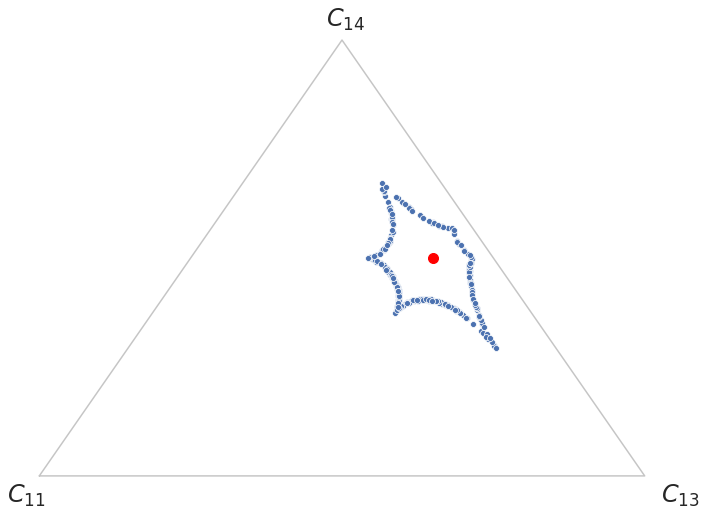

In [41]:
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = Pts, x=0, y=1, ax=ax);
ax.plot(*(Pt@T), 'o', markersize=10, color='red')
ax.plot([0,np.sqrt(2)/2, np.sqrt(2), 0], [0,np.sqrt(3/2), 0, 0], 'k', alpha=0.25);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

In [31]:
cdist(Pt, Pt, 'canberra')

ValueError: XA must be a 2-dimensional array.

In [37]:
test = graco.orbits(nx.erdos_renyi_graph(10,0.2))
t = test.iloc[:2,:]

In [35]:
cdist(test,test,'canberra').shape

(10, 10)

In [36]:
? cdist

In [ ]:
sqD = squareform(D)

In [ ]:
plt.hist(sqD, bins=50)

In [4]:
import numpy as np
from scipy.linalg import norm
from scipy.spatial.distance import euclidean

_SQRT2 = np.sqrt(2)     # sqrt(2) with default precision np.float64

def hellinger1(p, q):
    return norm(np.sqrt(p) - np.sqrt(q)) / _SQRT2


def hellinger2(p, q):
    return euclidean(np.sqrt(p), np.sqrt(q)) / _SQRT2


def hellinger3(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [9]:
n = 10
x = np.random.uniform(size=n)
x = x/np.sum(x)

y = np.random.uniform(size=n)
y = y/np.sum(y)

In [16]:
%%timeit
h1 = hellinger1(x,y)

8.3 µs ± 110 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [17]:
%%timeit
h2 = hellinger2(x,y)

11.5 µs ± 114 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [18]:
%%timeit
h3 = hellinger3(x,y)

6.28 µs ± 49.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# Confusion of the highest order

In [6]:
A_s = nx.to_scipy_sparse_matrix(PPI_nx)
A = pd.DataFrame(A_s.toarray(), columns=GDV.index, index=GDV.index)

Asq = A_s@A_s
T_s = (Asq).multiply(A_s)
T = pd.DataFrame(T_s.toarray(), columns=GDV.index, index=GDV.index)

D = pd.DataFrame((Asq-T_s).toarray(), columns=GDV.index, index=GDV.index)
np.fill_diagonal(D.values,0)

deg = np.array([d for n, d in PPI_nx.degree()])
B   = A*(deg-1)-T


(1*GDV['1']  + 2*GDV['3']                              == A@(GDV['0']-1)).all(), \
(1*GDV['4']  + 2*GDV['8']  + 2*GDV['9']  + 2*GDV['12'] == D@(GDV['0']-1)).all(), \
(1*GDV['10'] + 2*GDV['12'] + 6*GDV['14'] + 2*GDV['13'] == T@(GDV['0']-2)).all(), \
(2*GDV['6']  + 1*GDV['10'] + 2*GDV['9']  + 2*GDV['12'] == B@(GDV['0']-2)).all(), \
(1*GDV['5']  + 2*GDV['11'] + 2*GDV['8']  + 2*GDV['13'] == B.T@(GDV['0']-1)).all()

(True, True, True, True, True)

In [16]:
(1*GDV['1']  + 2*GDV['3'] == A_s@(GDV['0']-1)).all()

True

## Graphlet adjacency matrices

In [28]:
%%timeit
A = nx.to_scipy_sparse_matrix(PPI_nx)

Asq = A@A
T = Asq.multiply(A)

D = Asq-T
D.setdiag(0)

deg = np.array([d for n, d in PPI_nx.degree()])
B   = A.multiply(deg-1)-T

618 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
(1*GDV['1']  + 2*GDV['3']                              == A@(GDV['0']-1)).all(), \
(1*GDV['4']  + 2*GDV['8']  + 2*GDV['9']  + 2*GDV['12'] == D@(GDV['0']-1)).all(), \
(1*GDV['10'] + 2*GDV['12'] + 6*GDV['14'] + 2*GDV['13'] == T@(GDV['0']-2)).all(), \
(2*GDV['6']  + 1*GDV['10'] + 2*GDV['9']  + 2*GDV['12'] == B@(GDV['0']-2)).all(), \
(1*GDV['5']  + 2*GDV['11'] + 2*GDV['8']  + 2*GDV['13'] == B.T@(GDV['0']-1)).all()

(True, True, True, True, True)

In [219]:
GCV = graco.coefficients(PPI)

In [220]:
GCV['-1']

Source            0                   1                                \
Target            2         3         5         8        10        12   
YLR418C    0.716298  0.283702  0.465946  0.034344  0.448197  0.051513   
YOL145C    0.712994  0.287006  0.476994  0.037659  0.424194  0.061153   
YOR123C    0.527738  0.472262  0.373101  0.044974  0.486975  0.094950   
YBR279W    0.699565  0.300435  0.462896  0.038000  0.439884  0.059220   
YML069W    0.708524  0.291476  0.427786  0.028043  0.491394  0.052777   
...             ...       ...       ...       ...       ...       ...   
YFR018C         NaN       NaN       NaN       NaN       NaN       NaN   
YBR056W-A       NaN       NaN       NaN       NaN       NaN       NaN   
YOR278W         NaN       NaN       NaN       NaN       NaN       NaN   
YCR010C         NaN       NaN       NaN       NaN       NaN       NaN   
YBL029C-A       NaN       NaN       NaN       NaN       NaN       NaN   

Source            2                             3                      
Target            7        11        13        11        13        14  
YLR418C    0.574866  0.350676  0.074459  0.442697  0.375989  0.181314  
YOL145C    0.577081  0.339691  0.083229  0.421939  0.413522  0.164540  
YOR123C    0.320305  0.478586  0.201108  0.267403  0.449465  0.283133  
YBR279W    0.561325  0.348832  0.089842  0.406129  0.418395  0.175476  
YML069W    0.597563  0.317771  0.084666  0.386221  0.411613  0.202166  
...             ...       ...       ...       ...       ...       ...  
YFR018C         NaN       NaN       NaN       NaN       NaN       NaN  
YBR056W-A       NaN       NaN       NaN       NaN       NaN       NaN  
YOR278W         NaN       NaN       NaN       NaN       NaN       NaN  
YCR010C         NaN       NaN       NaN       NaN       NaN       NaN  
YBL029C-A       NaN       NaN       NaN       NaN       NaN       NaN  

[5726 rows x 12 columns]

In [235]:
df = pd.read_csv('/home/clusterduck123/Downloads/BIOGRID-IDENTIFIERS-3.5.178.tab.txt', 
            nrows=100, 
            skiprows=28, 
            delimiter='\t')

In [236]:
df

,BIOGRID_ID,IDENTIFIER_VALUE,IDENTIFIER_TYPE,ORGANISM_OFFICIAL_NAME
0,1,1,BIOGRID,Arabidopsis thaliana
1,1,ArthMr001,SYSTEMATIC NAME,Arabidopsis thaliana
2,1,ArthMr001,ORDERED LOCUS,Arabidopsis thaliana
3,1,rrn26,OFFICIAL SYMBOL,Arabidopsis thaliana
4,1,814566,ENTREZ_GENE,Arabidopsis thaliana
...,...,...,...,...
95,8,CCMF_ARATH,SYNONYM,Arabidopsis thaliana
96,8,CCMFC,SYNONYM,Arabidopsis thaliana
97,8,13449306,REFSEQ-PROTEIN-GI,Arabidopsis thaliana
98,8,NP_085489,REFSEQ-PROTEIN-ACCESSION,Arabidopsis thaliana


In [243]:
PPI_nx.number_of_edges()

92938

In [19]:
GCV

Order            -1                                                    \
Source            0                   1                                 
Target            2         3         5         8        10        12   
YLR418C    0.716298  0.283702  0.465946  0.034344  0.448197  0.051513   
YOL145C    0.712994  0.287006  0.476994  0.037659  0.424194  0.061153   
YOR123C    0.527738  0.472262  0.373101  0.044974  0.486975  0.094950   
YBR279W    0.699565  0.300435  0.462896  0.038000  0.439884  0.059220   
YML069W    0.708524  0.291476  0.427786  0.028043  0.491394  0.052777   
...             ...       ...       ...       ...       ...       ...   
YFR018C         NaN       NaN       NaN       NaN       NaN       NaN   
YBR056W-A       NaN       NaN       NaN       NaN       NaN       NaN   
YOR278W         NaN       NaN       NaN       NaN       NaN       NaN   
YCR010C         NaN       NaN       NaN       NaN       NaN       NaN   
YBL029C-A       NaN       NaN       NaN       NaN       NaN       NaN   

Order                                              ...         3            \
Source            2                             3  ...         3             
Target            7        11        13        11  ...        13        14   
YLR418C    0.574866  0.350676  0.074459  0.442697  ...  0.023302  0.022474   
YOL145C    0.577081  0.339691  0.083229  0.421939  ...  0.017191  0.013681   
YOR123C    0.320305  0.478586  0.201108  0.267403  ...  0.012511  0.015763   
YBR279W    0.561325  0.348832  0.089842  0.406129  ...  0.016421  0.013774   
YML069W    0.597563  0.317771  0.084666  0.386221  ...  0.025350  0.024902   
...             ...       ...       ...       ...  ...       ...       ...   
YFR018C         NaN       NaN       NaN       NaN  ...       NaN       NaN   
YBR056W-A       NaN       NaN       NaN       NaN  ...       NaN       NaN   
YOR278W         NaN       NaN       NaN       NaN  ...       NaN       NaN   
YCR010C         NaN       NaN       NaN       NaN  ...       NaN       NaN   
YBL029C-A       NaN       NaN       NaN       NaN  ...       NaN       NaN   

Order             1                                       2            \
Source            2                                       1             
Target            6         9        10        12         5         8   
YLR418C    0.968126  0.010999  0.018723  0.002152  0.860905  0.031728   
YOL145C    0.973733  0.010026  0.014195  0.002046  0.881963  0.034816   
YOR123C    0.976328  0.011348  0.010313  0.002011  0.858724  0.051756   
YBR279W    0.975150  0.010539  0.012613  0.001698  0.880444  0.036139   
YML069W    0.967358  0.010054  0.020397  0.002191  0.859680  0.028177   
...             ...       ...       ...       ...       ...       ...   
YFR018C    0.980742  0.019258  0.000000  0.000000       NaN       NaN   
YBR056W-A  0.984301  0.015699  0.000000  0.000000       NaN       NaN   
YOR278W    0.984301  0.015699  0.000000  0.000000       NaN       NaN   
YCR010C    0.948168  0.051832  0.000000  0.000000       NaN       NaN   
YBL029C-A  0.970364  0.029636  0.000000  0.000000       NaN       NaN   

Order                          
Source                         
Target           11        13  
YLR418C    0.026547  0.011273  
YOL145C    0.016243  0.007960  
YOR123C    0.010259  0.008622  
YBR279W    0.015602  0.008037  
YML069W    0.027388  0.014594  
...             ...       ...  
YFR018C         NaN       NaN  
YBR056W-A       NaN       NaN  
YOR278W         NaN       NaN  
YCR010C         NaN       NaN  
YBL029C-A       NaN       NaN  

[5726 rows x 30 columns]

In [20]:
G = nx.erdos_renyi_graph

0.0010000000000000009 0.001
0.0008703895286189265 0.024203025381693603


In [62]:
np.random.permutation(PPI.nodes())

array(['YGR085C', 'YNL207W', 'YPL221W', ..., 'YOL013W-A', 'YDR222W',
       'YJR136C'], dtype='<U9')

In [7]:
PPI = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
Genes = PPI.nodes()
gene2int = {gene:int for int,gene in enumerate(np.random.permutation(Genes),1)}
gene2int_df = pd.DataFrame({'gene':list(gene2int.keys()), 'int':list(gene2int.values())})
# save that shit!!!!!
G = nx.relabel_nodes(PPI, gene2int)
with open('hijo_de_puta.txt', 'w') as f:
    for n1,n2 in sorted(map(sorted,G.edges())):
        f.write(f"{n1} {n2} {G[n1][n2]['weight']}\n")

KeyError: 'weight'

In [5]:
sorted(map(sorted,G.edges()))

[[1, 885],
 [1, 1817],
 [1, 1968],
 [1, 2443],
 [1, 2530],
 [1, 3470],
 [1, 4674],
 [2, 72],
 [2, 310],
 [2, 881],
 [2, 1009],
 [2, 1570],
 [2, 1632],
 [2, 1968],
 [2, 2443],
 [2, 2570],
 [2, 4408],
 [2, 4435],
 [2, 4718],
 [3, 35],
 [3, 220],
 [3, 264],
 [3, 279],
 [3, 290],
 [3, 464],
 [3, 530],
 [3, 582],
 [3, 646],
 [3, 672],
 [3, 697],
 [3, 723],
 [3, 764],
 [3, 782],
 [3, 840],
 [3, 893],
 [3, 912],
 [3, 955],
 [3, 976],
 [3, 978],
 [3, 1091],
 [3, 1133],
 [3, 1160],
 [3, 1188],
 [3, 1197],
 [3, 1209],
 [3, 1237],
 [3, 1241],
 [3, 1251],
 [3, 1269],
 [3, 1388],
 [3, 1392],
 [3, 1436],
 [3, 1444],
 [3, 1477],
 [3, 1506],
 [3, 1538],
 [3, 1549],
 [3, 1557],
 [3, 1574],
 [3, 1584],
 [3, 1613],
 [3, 1662],
 [3, 1663],
 [3, 1690],
 [3, 1726],
 [3, 1751],
 [3, 1784],
 [3, 1808],
 [3, 1811],
 [3, 1814],
 [3, 1884],
 [3, 1914],
 [3, 1934],
 [3, 1996],
 [3, 2017],
 [3, 2060],
 [3, 2124],
 [3, 2164],
 [3, 2193],
 [3, 2221],
 [3, 2266],
 [3, 2463],
 [3, 2471],
 [3, 2478],
 [3, 2550],
 [3, 2

In [23]:
? sorted

In [51]:
nx.density(PPI)

0.0056701752673395086

In [30]:
D1 = np.loadtxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_GCV_canberra.txt", skiprows=1)
D2 = np.loadtxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_gGCV_normalizedl1.txt", skiprows=1)

In [32]:
pd.DataFrame(D1)

,0,1,2,3,4,5,6,7,8,9,...,5716,5717,5718,5719,5720,5721,5722,5723,5724,5725
0,0.000000,2.081907,4.975540,2.127163,1.107894,3.783905,5.401809,2.269301,6.087600,3.825032,...,27.254544,25.545573,25.545573,25.545573,25.545573,25.545573,25.337674,25.337674,26.148174,26.032264
1,2.081907,0.000000,3.731251,0.755341,2.655792,3.832037,6.829980,3.707082,7.301493,5.444807,...,27.313537,25.474394,25.474394,25.474394,25.474394,25.474394,25.339577,25.339577,26.289704,26.176669
2,4.975540,3.731251,0.000000,3.454085,5.146380,6.312529,9.503018,4.873624,10.101591,7.329279,...,27.302410,25.387233,25.387233,25.387233,25.387233,25.387233,25.256950,25.256950,26.268039,26.140591
3,2.127163,0.755341,3.454085,0.000000,2.717591,3.986635,7.201675,3.356022,7.798207,5.185276,...,27.290357,25.442116,25.442116,25.442116,25.442116,25.442116,25.298413,25.298413,26.251928,26.133955
4,1.107894,2.655792,5.146380,2.717591,0.000000,4.558886,5.406316,1.715964,5.903534,3.437346,...,27.262162,25.593029,25.593029,25.593029,25.593029,25.593029,25.386909,25.386909,26.172508,26.067095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5721,25.545573,25.474394,25.387233,25.442116,25.593029,25.744400,25.789848,25.603299,25.757838,25.742695,...,2.236390,0.000000,0.000000,0.000000,0.000000,0.000000,0.260759,0.260759,1.134753,0.950149
5722,25.337674,25.339577,25.256950,25.298413,25.386909,25.694228,25.548189,25.425854,25.615130,25.498363,...,2.194183,0.260759,0.260759,0.260759,0.260759,0.260759,0.000000,0.000000,1.076682,0.916654
5723,25.337674,25.339577,25.256950,25.298413,25.386909,25.694228,25.548189,25.425854,25.615130,25.498363,...,2.194183,0.260759,0.260759,0.260759,0.260759,0.260759,0.000000,0.000000,1.076682,0.916654
5724,26.148174,26.289704,26.268039,26.251928,26.172508,25.490278,25.875309,26.269419,26.107472,26.086973,...,1.780094,1.134753,1.134753,1.134753,1.134753,1.134753,1.076682,1.076682,0.000000,0.378776


In [35]:
pd.DataFrame(D2)*30

,0,1,2,3,4,5,6,7,8,9,...,5716,5717,5718,5719,5720,5721,5722,5723,5724,5725
0,0.000000,1.976760,5.148246,2.060250,1.057197,3.406167,5.523711,2.266542,6.175908,3.509430,...,20.716050,16.443624,16.443624,16.443624,16.443624,16.443624,15.923877,15.923877,17.950125,17.660349
1,1.976760,0.000000,3.914394,0.702108,2.494509,3.396090,6.889917,3.645624,7.362684,5.070318,...,20.835693,16.237836,16.237836,16.237836,16.237836,16.237836,15.900792,15.900792,18.276108,17.993523
2,5.148246,3.914394,0.000000,3.614949,5.265483,6.250716,9.793434,4.818993,10.356192,7.177842,...,20.798133,16.010193,16.010193,16.010193,16.010193,16.010193,15.684486,15.684486,18.212208,17.893587
3,2.060250,0.702108,3.614949,0.000000,2.566680,3.594393,7.263216,3.306906,7.838727,4.838343,...,20.776338,16.155738,16.155738,16.155738,16.155738,16.155738,15.796479,15.796479,18.180267,17.885331
4,1.057197,2.494509,5.265483,2.566680,0.000000,4.169814,5.549934,1.735227,6.043221,3.185829,...,20.741775,16.568940,16.568940,16.568940,16.568940,16.568940,16.053642,16.053642,18.017640,17.754108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5721,16.443624,16.237836,16.010193,16.155738,16.568940,16.919754,17.132607,16.599306,17.055588,16.975302,...,5.590977,0.000000,0.000000,0.000000,0.000000,0.000000,0.651897,0.651897,2.836884,2.375373
5722,15.923877,15.900792,15.684486,15.796479,16.053642,16.794327,16.528458,16.155693,16.698816,16.364472,...,5.485458,0.651897,0.651897,0.651897,0.651897,0.651897,0.000000,0.000000,2.691705,2.291634
5723,15.923877,15.900792,15.684486,15.796479,16.053642,16.794327,16.528458,16.155693,16.698816,16.364472,...,5.485458,0.651897,0.651897,0.651897,0.651897,0.651897,0.000000,0.000000,2.691705,2.291634
5724,17.950125,18.276108,18.212208,18.180267,18.017640,16.284450,17.346258,18.264606,17.929671,17.835996,...,4.450236,2.836884,2.836884,2.836884,2.836884,2.836884,2.691705,2.691705,0.000000,0.946941


# Cluster generator

In [5]:
def get_number_of_max_runs(GV, distance, n_clusters = 100):
    runs = max(int(run) for run,species,db,ncluster_txt in 
             map(partial(str.split, sep='_'), os.listdir(f"{CLUSTERS_DIRECTORY}/{GV}/{distance}"))
                if int(ncluster_txt.split('.')[0]) == n_clusters)
    return runs

In [6]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 100

In [9]:
# Automated
for run in range(49):
    for distance in ['normalizedl2']:
        print(distance)

        if not os.path.exists(f"{CLUSTERS_DIRECTORY}/gGCV/{distance}"):
            os.makedirs(f"{CLUSTERS_DIRECTORY}/gGCV/{distance}")

        MATRIX_NAME = f"sc_BioGRID_gGCV_{distance}"
        with open(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", 'r') as f:
            line = f.readline()
        D = np.loadtxt(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", skiprows=1)

        int2gene = dict(enumerate(line.split()))
        
        t1 = time.time()
        for n_clusters in range(2, 100):
            nr = get_number_of_max_runs('gGCV', distance, MAX_CLUSTERS-1) # CAREFULL !!!!!
            initial_medoids = random.sample(range(len(D)), n_clusters)
            kmedoids_instance = kmedoids(D, initial_medoids, data_type='distance_matrix')
            kmedoids_instance.process()

            with open(f"{CLUSTERS_DIRECTORY}/gGCV/{distance}/{nr+1}_sc_BioGRID_{n_clusters}.txt", 'w') as f:
                for cluster in kmedoids_instance.get_clusters():
                    f.write(' '.join(map(int2gene.get,cluster)) + '\n')
            t2 = time.time()
            print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')
        print()

normalizedl2
99: 499.35sec
normalizedl2
99: 513.73sec
normalizedl2
99: 552.03sec
normalizedl2
99: 546.49sec
normalizedl2
99: 562.08sec
normalizedl2
99: 554.41sec
normalizedl2
99: 513.50sec
normalizedl2
99: 509.94sec
normalizedl2
99: 509.93sec
normalizedl2
99: 523.46sec
normalizedl2
99: 512.90sec
normalizedl2
99: 508.42sec
normalizedl2
99: 508.83sec
normalizedl2
99: 507.78sec
normalizedl2
99: 507.91sec
normalizedl2
99: 507.76sec
normalizedl2
99: 507.51sec
normalizedl2
99: 508.44sec
normalizedl2
99: 507.32sec
normalizedl2
99: 507.81sec
normalizedl2
99: 507.28sec
normalizedl2
99: 509.49sec
normalizedl2
99: 508.05sec
normalizedl2
99: 508.71sec
normalizedl2
99: 507.10sec
normalizedl2
99: 508.92sec
normalizedl2
99: 508.53sec
normalizedl2
99: 508.09sec
normalizedl2
99: 507.60sec
normalizedl2
99: 508.49sec
normalizedl2
99: 508.71sec
normalizedl2
99: 508.98sec
normalizedl2
99: 508.67sec
normalizedl2
99: 507.53sec
normalizedl2
99: 507.66sec
normalizedl2
99: 508.16sec
normalizedl2
99: 507.98sec
n